In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from joblib import delayed, Parallel
from sklearn.decomposition import PCA
from utils import calcular_estatisticas, imprimir_estatisticas, rejeitar_hip_nula, do_cv, print_t_tests
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ttest_ind_from_stats

# Fazendo leitura do dataset e removendo a coluna 'winning_team' de X, e pegando somente essa coluna para as labels y

In [2]:
df = pd.read_csv('dota2DatasetTrain_header_01.csv')
X = df.drop(['winning_team'], axis=1)
y = df['winning_team']

# Normalizando os dados

In [3]:
scaler = StandardScaler()
scaler.fit(X)
X_pca = scaler.transform(X) 

pca = PCA(n_components=2)
pca.fit(X_pca)
X_pca = pca.transform(X_pca)
X_pca_df = pd.DataFrame(X_pca, columns=['PC0', 'PC1'])

<Axes: xlabel='PC0', ylabel='PC1'>

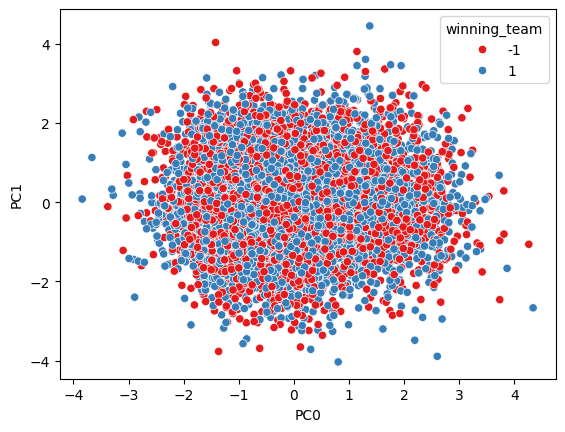

In [4]:
sns.set_palette('seismic')
sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue=y, palette='Set1')

# Avaliando desempenho do classificador KNN com validação cruzada de 2 níveis

In [5]:
resultados = {}

In [6]:
k1 = 10 #controla o número de vias da validação cruzada para estimar o desempenho do modelo
k2 = 5 #controla o número de vida da validação cruzada para otimização de hiperparametros

#usar o protocolo de validação cruzada estratificada
skf = StratifiedKFold(n_splits=k1, shuffle=True, random_state=1)

conf_matrix = None
acuracias = []

#a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
for idx_treino, idx_teste in skf.split(X, y):
    
    #extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
    X_treino = X.iloc[idx_treino]
    y_treino = y.iloc[idx_treino]
    
    #extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
    X_teste = X.iloc[idx_teste]
    y_teste = y.iloc[idx_teste]
    
    #colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)
    
    #combinações de parametros otimizar. Aqui estamos apenas otimizando o número de vizinhos mais próximos para o knn (k).
    #Entretanto, podemos colocar todos os valores de todos os parametros. O sklearn se encarrega de gerar todas as combinações.
    params = {'n_neighbors' : range(1,30,2)}

    #instanciar um KNN com parametros padrão
    knn = KNeighborsClassifier()

    #instanciar um GridSearchCV com k2 vias.
    knn = GridSearchCV(knn, params, cv=StratifiedKFold(n_splits=k2), scoring='f1_macro')
    
    #realizar a otimização dos hiperparâmetros e treinar o modelo final com a melhor combinação de hiperparametros com todos os dados de treinamento
    knn.fit(X_treino, y_treino)

    pred = knn.predict(X_teste)
    print(classification_report(y_teste, pred, zero_division=0))
    
    cm = confusion_matrix(y_teste, pred)
    if conf_matrix is None:
        conf_matrix = cm
    else:
        conf_matrix += cm

    f1 = f1_score(y_teste, pred, average='weighted')
    acuracias.append(f1)

print('Matriz de confusão: ')
print(conf_matrix)    

resultados['knn'] = acuracias

              precision    recall  f1-score   support

          -1       0.50      0.45      0.47       439
           1       0.55      0.60      0.57       488

    accuracy                           0.53       927
   macro avg       0.53      0.53      0.52       927
weighted avg       0.53      0.53      0.53       927

              precision    recall  f1-score   support

          -1       0.44      0.38      0.41       439
           1       0.50      0.56      0.53       488

    accuracy                           0.48       927
   macro avg       0.47      0.47      0.47       927
weighted avg       0.47      0.48      0.47       927

              precision    recall  f1-score   support

          -1       0.56      0.48      0.52       439
           1       0.58      0.65      0.62       488

    accuracy                           0.57       927
   macro avg       0.57      0.57      0.57       927
weighted avg       0.57      0.57      0.57       927

              preci

In [7]:
def selecionar_melhor_svm(Cs, Gammas, X_treino, X_val, y_treino, y_val):
    acuracias_val = []

    for C in Cs:
        for gamma in Gammas:
            svm = SVC(C=C, gamma=gamma, kernel='rbf')
            svm.fit(X_treino, y_treino)
            pred = svm.predict(X_val)
            acuracias_val.append(accuracy_score(y_val, pred))

    melhor_valor = np.max(acuracias_val)
    melhor_C = Cs[np.argmax(acuracias_val) // len(Gammas)]
    melhor_gamma = Gammas[np.argmax(acuracias_val) % len(Gammas)]
    svm = SVC(C=melhor_C, gamma=melhor_gamma, kernel='rbf')
    svm.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])

    return svm, melhor_valor, melhor_C, melhor_gamma

# Avaliando desempenho do classificador SVM com validação cruzada de 1 nível

In [8]:
#a validação cruzada será realizada em 10 vias.
k_vias = 10

#usar o protocolo de validação cruzada estratificada
skf = StratifiedKFold(n_splits=k_vias, shuffle=True, random_state=1)

pgb = tqdm(total=k_vias, desc='Folds avaliados')

acuracias = []

#a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
for idx_treino, idx_teste in skf.split(X, y):
    
    #extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
    X_treino = X.iloc[idx_treino]
    y_treino = y.iloc[idx_treino]
    
    #extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
    X_teste = X.iloc[idx_teste]
    y_teste = y.iloc[idx_teste]
    
    #separar as instâncias de treinamento entre treinamento e validação para a otimização do hiperparâmetro k
    X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=0.2, stratify=y_treino, shuffle=True, random_state=1)
    
    #colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)
    X_val = ss.transform(X_val)

    #valores de C e gamma a serem testados
    C_values = [0.1, 1, 10, 100, 1000]
    gamma_values = ['scale', 'auto', 2e-2, 2e-3, 2e-4]

    svm, melhor_valor, melhor_C, melhor_gamma = selecionar_melhor_svm(C_values, gamma_values, X_treino, X_val, y_treino, y_val)
    
    #calcular a acurácia no conjunto de testes desta iteração e salvar na lista.
    # acuracias.append(accuracy_score(y_teste, svm.predict(X_teste)))
    pred = svm.predict(X_teste)
    f1 = f1_score(y_teste, pred, average='weighted')
    acuracias.append(f1)
    
    pgb.update(1)
        
pgb.close()
    
resultados['svm'] = acuracias

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

# Avaliando desempenho do classificador Random Forest com validação cruzada de 2 níveis

In [9]:
k1 = 10 #controla o número de vias da validação cruzada para estimar o desempenho do modelo
k2 = 5 #controla o número de vida da validação cruzada para otimização de hiperparametros

# usar o protocolo de validação cruzada estratificada
skf = StratifiedKFold(n_splits=k1, shuffle=True, random_state=1)
pgb = tqdm(total=k1, desc='Folds avaliados')

rf_conf_matrix = None
acuracias = []

# a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
for idx_treino, idx_teste in skf.split(X, y):

    # extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
    X_treino = X.iloc[idx_treino]
    y_treino = y.iloc[idx_treino]

    # extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
    X_teste = X.iloc[idx_teste]
    y_teste = y.iloc[idx_teste]

    # colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)

    # combinações de parametros otimizar. Aqui estamos apenas otimizando o número de vizinhos mais próximos para o knn (k).
    # Entretanto, podemos colocar todos os valores de todos os parametros. O sklearn se encarrega de gerar todas as combinações.
    params={
        'criterion' : ['gini', 'entropy'], 
        'random_state' : [1], 
        'n_estimators': [100, 200, 500],
    }

    # instanciar um KNN com parametros padrão
    rf = RandomForestClassifier()

    # instanciar um GridSearchCV com k2 vias
    rf = GridSearchCV(rf, params, cv=StratifiedKFold(n_splits=k2), scoring='f1_macro')
    
    # realizar a otimização dos hiperparâmetros e treinar o modelo final com a melhor combinação de hiperparametros com todos os dados de treinamento
    rf.fit(X_treino, y_treino)

    # predizer os dados de teste usando o modelo treinado
    pred = rf.predict(X_teste)

    # calcular a acurácia do modelo na base de teste e imprimir
    print(classification_report(y_teste, pred))

    # calcular a matriz de confusão do modelo na base de teste e imprimir
    cm = confusion_matrix(y_teste, pred)
    if rf_conf_matrix is None:
        rf_conf_matrix = cm
    else:
        rf_conf_matrix += cm

    f1 = f1_score(y_teste, pred, average='macro')
    acuracias.append(f1)
    pgb.update(1)


print("Soma das matrizes de confusão:")
print(conf_matrix)

pgb.close()

resultados['rf'] = acuracias

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          -1       0.55      0.47      0.51       439
           1       0.58      0.65      0.61       488

    accuracy                           0.57       927
   macro avg       0.56      0.56      0.56       927
weighted avg       0.56      0.57      0.56       927

              precision    recall  f1-score   support

          -1       0.51      0.44      0.47       439
           1       0.55      0.62      0.58       488

    accuracy                           0.54       927
   macro avg       0.53      0.53      0.53       927
weighted avg       0.53      0.54      0.53       927

              precision    recall  f1-score   support

          -1       0.57      0.46      0.51       439
           1       0.59      0.69      0.63       488

    accuracy                           0.58       927
   macro avg       0.58      0.57      0.57       927
weighted avg       0.58      0.58      0.57       927

              preci

# Imprimindo o resultado para todos os testes realizados e mostrando testes T para cada um

In [10]:
for teste in sorted(resultados):
    print(teste.rjust(10), end=' - ')
    imprimir_estatisticas(resultados[teste])

print()

print_t_tests(resultados, alpha=0.05)

       knn - Resultados: 0.53 +- 0.03, min: 0.47, max: 0.57
        rf - Resultados: 0.55 +- 0.01, min: 0.53, max: 0.57
       svm - Resultados: 0.58 +- 0.02, min: 0.55, max: 0.61

                knn          rf         svm     
    knn         1.00     0.01 (*<)   0.00 (*<)  
     rf      0.01 (*>)      1.00     0.00 (*<)  
    svm      0.00 (*>)   0.00 (*>)      1.00    


# Aplicando redução de dimensionalidade utilizando PCA

In [12]:
svm_teste = ('svm', SVC, True, {'C' : [0.1, 1, 10, 100, 1000], 'gamma' : ['scale', 'auto', 2e-2, 2e-3, 2e-4], 'kernel': ['rbf']})
knn_teste = ('knn', KNeighborsClassifier, True, {'n_neighbors' : range(1,30,2)})
rf_teste = ('rf', RandomForestClassifier, True, {
        'criterion' : ['gini', 'entropy'], 
        'random_state' : [1],
        'n_estimators': [100, 200, 500],
})

testes = [svm_teste, knn_teste, rf_teste]

for n_components in [2, 8, 16, 32, 64]:
    print("n_components: %d" % (n_components))
    pca = PCA(n_components=n_components)
    for nome, classificador, scale, params in testes:
        nome = "%s_pca=%02d" % (nome, n_components)
        print("Executando teste %s" % (nome))
        if nome == 'svm':
            r = do_cv(classificador, X, y, 10, None, 8, scale, None, pca, params)
        else:
            r = do_cv(classificador, X, y, 10, 5, 8, scale, None, pca, params)
        resultados[nome] = r

n_components: 2
Executando teste svm_pca=02


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_pca=02


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_pca=02


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

n_components: 8
Executando teste svm_pca=08


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_pca=08


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_pca=08


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

n_components: 16
Executando teste svm_pca=16


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_pca=16


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_pca=16


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

n_components: 32
Executando teste svm_pca=32


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_pca=32


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_pca=32


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

n_components: 64
Executando teste svm_pca=64


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste knn_pca=64


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Executando teste rf_pca=64


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

# Aplicando teste de hipótese com Teste T Student

In [14]:
print(resultados)

for teste in sorted(resultados):
    print(teste.rjust(10), end=' - ')
    imprimir_estatisticas(resultados[teste])

print()

print_t_tests(resultados, cols=['knn', 'rf', 'svm'])

{'knn': [0.5270890195084544, 0.4730795619592059, 0.5696887863321929, 0.5245945338801447, 0.5417078949965193, 0.5168729900389283, 0.5298918343270775, 0.5009131092929072, 0.5400789004581099, 0.5473141563485777], 'svm': [0.5886992486078066, 0.5586190241748826, 0.6052998919340976, 0.5460286358104581, 0.5810712323579277, 0.5748796382315863, 0.597312467103472, 0.5629951236669829, 0.5907300493250803, 0.5881736088426489], 'rf': [0.5588242588142209, 0.5296348566519716, 0.569893880270296, 0.5634643053215455, 0.5575780812221666, 0.550035854468599, 0.5484701727476293, 0.5548076923076923, 0.5467600235604483, 0.5506620651129321], 'svm_pca=02': [0.6897526501766785, 0.6897526501766785, 0.6897526501766785, 0.6897526501766785, 0.6902404526166902, 0.6902404526166902, 0.6902404526166902, 0.6902404526166902, 0.689313517338995, 0.689313517338995], 'knn_pca=02': [0.5554484088717455, 0.566990291262136, 0.566355140186916, 0.5747126436781609, 0.5752895752895753, 0.51171875, 0.5692883895131087, 0.563017479300827

# Usando os dados exibidos nos itens 6 e 7 acima, indique e justifique quais foram os melhores resultados obtidos. Identifique e justifique também os piores resultados obtidos. Você notou algum padrão interessante? Quais?

Os melhores resultados obtidos nos testes realizados foram aqueles em que não foi aplicado a redução de dimensionalidade, para ocorrer isso, pode ter acontecido de ao reduzir essa dimensionaliade, alguns dados importantes podem ter sido perdidos. Conforme os resultados obtidos pelos classificadores e realizando testes T para cada um deles, podemos notar que o melhor classificador em nosso caso para este dataset disponibilizado foi o SVM. 